In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [148]:
#reduce  NILM images, use more SCC images
#make HSIL and LSIL 200 something

In [2]:
IMAGE_SHAPE=(224,224)

In [32]:
import pathlib
data_dir=pathlib.Path("/home/sanjana/Desktop/Final_Year_Proj/dataset_original/resized")
data_dir2=pathlib.Path("/home/sanjana/Desktop/Final_Year_Proj/dataset_original/FYP/sharp-only")

In [33]:
lesions_dict={
    'NILM': list(data_dir.glob('NILM_resized/NILM/*')),
    'LSIL': list(data_dir.glob('LSIL_resized/LSIL/*')),
    'HSIL': list(data_dir.glob('HSIL_resized/HSIL/*')),
    'SCC': list(data_dir.glob('SCC_resized/SCC/*')),
}

In [34]:

lesions_dict_aug={
    #'nilm': list(data_dir2.glob('NILM_test/*')),
    'lsil': list(data_dir2.glob('lsil/*')),
    'hsil': list(data_dir2.glob('hsil/*')),
    'scc': list(data_dir2.glob('scc/*')),
}


In [35]:
lesions_labels={
    'NILM': 0,
    'LSIL': 1,
    'HSIL': 2,
    'SCC': 3,
}

In [36]:

lesions_labels_aug={
    #'NILM-test': 0,
    'lsil': 1,
    'hsil': 2,
    'scc': 3,
}

In [37]:
x, y=[],[]
for lesions_name, images in lesions_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        x.append(img)
        y.append(lesions_labels[lesions_name])

In [38]:
x_aug, y_aug=[],[]
for lesions_name, images in lesions_dict_aug.items():
    for image in images:
        img=cv2.imread(str(image))
        x_aug.append(img)
        y_aug.append(lesions_labels_aug[lesions_name])

In [39]:
len(x)

962

In [40]:
len(x_aug)

281

In [41]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1, shuffle = True)
x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [42]:
print(len(x_train), len(x_val), len(x_test))

778 87 97


In [43]:
x_train = x_train + x_aug
y_train = y_train + y_aug

In [44]:
print(len(x_train), len(x_val), len(x_test))

1059 87 97


In [45]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [46]:
x_val=np.array(x_val)
y_val=np.array(y_val)

In [47]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [48]:
x_train_scaled=x_train/255
x_val_scaled=x_val/255
x_test_scaled = x_test/255
print(len(x_train_scaled), len(y_train))
print(len(x_val_scaled), len(y_val))
print(len(x_test_scaled), len(y_test))

1059 1059
87 87
97 97


In [49]:
#reduce test and validation images, increase training images
#increase number of epochs

In [50]:

classifier="https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
mod=hub.KerasLayer(classifier, input_shape=(224,224,3), trainable=False)


In [51]:
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

In [54]:
import matplotlib.pyplot as plt
acc_per_fold=[]
loss_per_fold=[]
num_lesions=4
model=tf.keras.Sequential([
    mod, 
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(num_lesions)
])

model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

history = model.fit(x_train_scaled, y_train, batch_size=20,epochs=20,callbacks = es, validation_data = (x_val_scaled, y_val))
    


Epoch 1/20
53/53 [==============================] - 47s 854ms/step - loss: 0.3194 - acc: 0.8905 - val_loss: 0.1277 - val_acc: 0.9425
Epoch 2/20
53/53 [==============================] - 41s 777ms/step - loss: 0.0687 - acc: 0.9811 - val_loss: 0.1177 - val_acc: 0.9655
Epoch 3/20
53/53 [==============================] - 42s 804ms/step - loss: 0.0413 - acc: 0.9915 - val_loss: 0.0655 - val_acc: 0.9655
Epoch 4/20
53/53 [==============================] - 46s 860ms/step - loss: 0.0306 - acc: 0.9915 - val_loss: 0.0454 - val_acc: 0.9885
Epoch 5/20
53/53 [==============================] - 48s 915ms/step - loss: 0.0188 - acc: 0.9981 - val_loss: 0.0328 - val_acc: 0.9885
Epoch 6/20
53/53 [==============================] - 45s 841ms/step - loss: 0.0176 - acc: 0.9953 - val_loss: 0.0298 - val_acc: 1.0000
Epoch 7/20
53/53 [==============================] - 41s 778ms/step - loss: 0.0116 - acc: 0.9962 - val_loss: 0.0239 - val_acc: 1.0000
Epoch 8/20
53/53 [==============================] - 45s 855ms/step - 

In [55]:
print("Testing accuracy: \n")
print(model.evaluate(x_test_scaled, y_test))

Testing accuracy: 

4/4 [==============================] - 4s 773ms/step - loss: 0.0267 - acc: 0.9897
[0.026732373982667923, 0.9896907210350037]


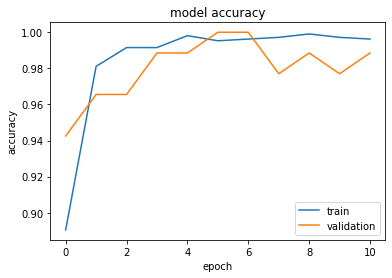

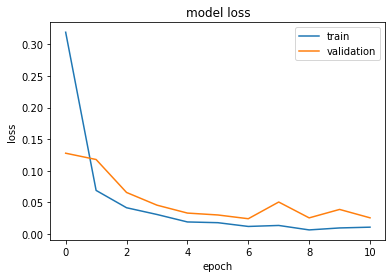

In [56]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [57]:
print("Testing accuracy: \n")
print(model.evaluate(x_test_scaled, y_test))

Testing accuracy: 

4/4 [==============================] - 4s 777ms/step - loss: 0.0267 - acc: 0.9897
[0.026732373982667923, 0.9896907210350037]


In [58]:
preds=model.predict(x_test_scaled)
pred_classes=np.argmax(preds, axis=1)
pred_classes

4/4 [==============================] - 4s 852ms/step


array([0, 2, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 3, 2, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 2, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 3, 0, 2, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 3, 0, 2, 0, 1])

In [28]:
class_labels=[0,1,2,3]
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, pred_classes, class_labels)
print(report) 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_classes)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00         7

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97



/home/sanjana/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([[65,  0,  0,  0],
       [ 0, 12,  0,  0],
       [ 0,  0, 13,  0],
       [ 0,  0,  0,  7]])